<a href="https://colab.research.google.com/github/DifferentiableUniverseInitiative/JaxPM/blob/main/notebooks/02-MultiGPU_PM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install --quiet git+https://github.com/DifferentiableUniverseInitiative/JaxPM.git
!pip install diffrax

In [1]:
%load_ext autoreload
%autoreload 2
import os
os.environ["EQX_ON_ERROR"] = "nan"
import jax
import jax.numpy as jnp
import jax_cosmo as jc

from jax.experimental.ode import odeint
from jaxpm.kernels import interpolate_power_spectrum
from jaxpm.painting import cic_paint , cic_paint_dx
from jaxpm.pm import linear_field, lpt, make_ode_fn
from diffrax import ConstantStepSize, LeapfrogMidpoint, ODETerm, SaveAt, diffeqsolve

In [2]:
assert jax.device_count() >= 8, "This notebook requires a TPU or GPU runtime with 8 devices"

In [3]:
from jax.experimental.mesh_utils import create_device_mesh
from jax.experimental.multihost_utils import process_allgather
from jax.sharding import Mesh, NamedSharding
from jax.sharding import PartitionSpec as P
from functools import partial

all_gather = partial(process_allgather, tiled=True)

pdims = (2, 4)
devices = create_device_mesh(pdims)
mesh = Mesh(devices, axis_names=('x', 'y'))
sharding = NamedSharding(mesh, P('x', 'y'))

In [4]:
mesh_shape = [512, 512, 512]
box_size = [500., 500., 1000.]
halo_size = 128
snapshots = jnp.linspace(0.1,1.,2)

@jax.jit
def run_simulation(omega_c, sigma8):
    # Create a small function to generate the matter power spectrum
    k = jnp.logspace(-4, 1, 128)
    pk = jc.power.linear_matter_power(
        jc.Planck15(Omega_c=omega_c, sigma8=sigma8), k)
    pk_fn = lambda x: interpolate_power_spectrum(x, k, pk, sharding)

    # Create initial conditions
    initial_conditions = linear_field(mesh_shape,
                                      box_size,
                                      pk_fn,
                                      seed=jax.random.PRNGKey(0),
                                      sharding=sharding)


    cosmo = jc.Planck15(Omega_c=omega_c, sigma8=sigma8)

    # Initial displacement
    dx, p, f = lpt(cosmo,
                   initial_conditions,
                   a=0.1,
                   order=1,
                   halo_size=halo_size,
                   sharding=sharding)

    # Evolve the simulation forward
    ode_fn = make_ode_fn(mesh_shape, halo_size=halo_size, sharding=sharding)
    term = ODETerm(lambda t, state, args: jnp.stack(ode_fn(state, t, args), axis=0))
    solver = LeapfrogMidpoint()

    stepsize_controller = ConstantStepSize()
    res = diffeqsolve(term,
                      solver,
                      t0=0.1,
                      t1=1.,
                      dt0=0.01,
                      y0=jnp.stack([dx, p], axis=0),
                      args=cosmo,
                      saveat=SaveAt(ts=snapshots),
                      stepsize_controller=stepsize_controller)

    return initial_conditions, dx, res.ys, res.stats

initial_conditions , lpt_displacements , ode_solutions , solver_stats = run_simulation(0.25, 0.8)
%timeit initial_conditions , lpt_displacements , ode_solutions , solver_stats = run_simulation(0.25, 0.8)
print(f"Solver Stats : {solver_stats}")

6.62 s ± 1.24 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Solver Stats : {'max_steps': Array(4096, dtype=int32, weak_type=True), 'num_accepted_steps': Array(90, dtype=int32, weak_type=True), 'num_rejected_steps': Array(0, dtype=int32, weak_type=True), 'num_steps': Array(90, dtype=int32, weak_type=True)}


In [5]:
initial_conditions = all_gather(initial_conditions)
lpt_displacements = all_gather(lpt_displacements)
ode_solutions = [all_gather(p) for p in ode_solutions]

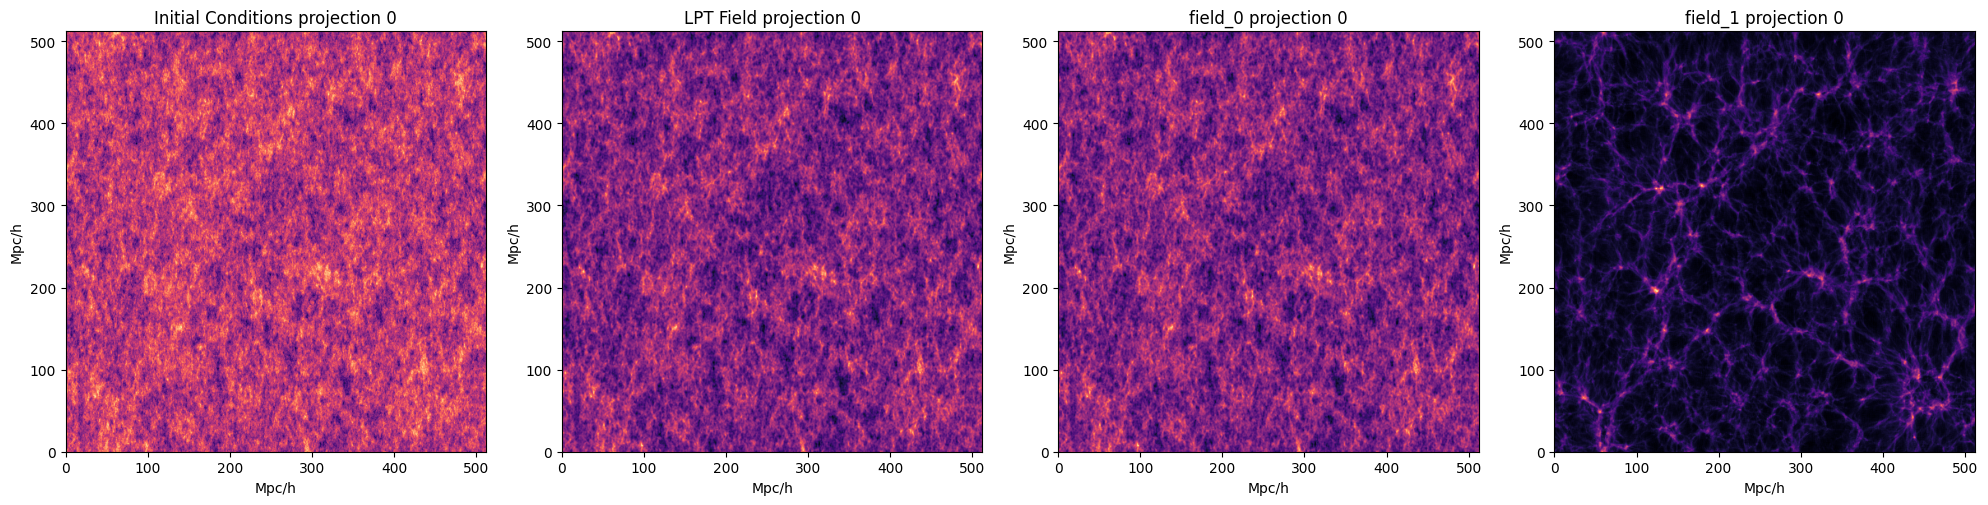

In [6]:
from visualize import plot_fields_single_projection

fields = {"Initial Conditions" : initial_conditions , "LPT Field" : cic_paint_dx(lpt_displacements)}
for i , field in enumerate(ode_solutions):
    fields[f"field_{i}"] = cic_paint_dx(field[0])
plot_fields_single_projection(fields)